In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import f
from scipy import stats
import seaborn
from math import sqrt
from scipy.stats import t
seaborn.set_theme()
import pandas as pd

#### Generate data sample

In [20]:
lambda_1 = 100
lambda_2 = 110
dataset_size = 500

exp_1 = expon(loc=0, scale=lambda_1)
exp_2 = expon(loc=0, scale=lambda_2)
dataset_1 = [exp_1.rvs() for _ in range(dataset_size)]
dataset_2 = [exp_2.rvs() for _ in range(dataset_size)]

#### Visualize distributions and data samples

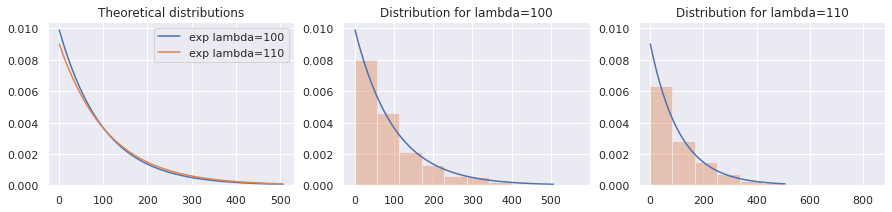

In [21]:
fig, ax = plt.subplots(1, 3)

x = np.linspace(min(exp_1.ppf(0.01), exp_2.ppf(0.01)),
                max(exp_1.ppf(0.99), exp_2.ppf(0.99)), 100)
exp_1_lin = exp_1.pdf(x)
exp_2_lin = exp_2.pdf(x)
ax[0].plot(x, exp_1_lin,label='exp lambda='+str(lambda_1))
ax[0].plot(x, exp_2_lin, label='exp lambda='+str(lambda_2))
ax[0].set_title('Theoretical distributions')
ax[0].legend()

ax[1].plot(x, exp_1_lin,label='exp lambda='+str(lambda_1))
ax[1].hist(dataset_1, alpha = 0.4, density = True)
ax[1].set_title('Distribution for lambda='+str(lambda_1))

ax[2].plot(x, exp_2_lin,label='exp lambda='+str(lambda_2))
ax[2].hist(dataset_2, alpha = 0.4, density = True)
ax[2].set_title('Distribution for lambda='+str(lambda_2))

for i in range(3):
    ax[i].set_ylim(0, max(np.concatenate([exp_1_lin,exp_2_lin]))*1.05)
    
fig.set_size_inches(15, 3)
plt.show()

#### Helpful functions for tests

In [22]:
def f_bootstrap(dataset, func, rep = 10000, **kwargs):
    bootstrap_mean_list = []
    data_len = len(dataset)
    for _ in range(rep):
        elem = func(np.random.choice(dataset, data_len), **kwargs)
        bootstrap_mean_list = bootstrap_mean_list + [elem]
    return bootstrap_mean_list

def f_bootstrap_for_dif(dataset_1, dataset_2, func, rep = 20000, **kwargs):
    bootstrap_list = []
    for _ in range(rep):
        elem = func(np.random.choice(dataset_2, len(dataset_2)), **kwargs) - func(np.random.choice(dataset_1, len(dataset_1)), **kwargs)
        bootstrap_list = bootstrap_list + [elem]
    return bootstrap_list

def f_bootstrap_for_ration_of_means(dataset_1, dataset_2, rep = 20000):
    bootstrap_list = []
    for _ in range(rep):
        elem = np.mean(np.random.choice(dataset_2, len(dataset_2))) / np.mean(np.random.choice(dataset_1, len(dataset_1)))
        bootstrap_list = bootstrap_list + [elem]
    return bootstrap_list

def f_bootstrap_p_value(bootstrap_list):
    s = len(bootstrap_list)
    p = len([i for i in bootstrap_list if i < 0])
    p_value_1s = min(p/s, (s-p)/s)
    return p_value_1s

def fun_get_df_in_ttest(a_var, b_var, a_len, b_len):
    return (a_var/a_len + b_var/b_len)**2 / ( a_var**2/(a_len**2 * (a_len - 1)) + b_var**2/(b_len**2 * (b_len - 1))) 

def f_make_bootstrap_with_draw(dataset_list, lambda_list, func, **kwargs):
    fig, ax = plt.subplots(1, 2)

    for i in range(2):
        b_l = f_bootstrap(dataset_list[i], func, **kwargs)
        ax[0].hist(b_l, density = True, alpha = 0.4, label = 'lambda='+str(lambda_list[i]))
        ax[0].axvline(x=func(dataset_list[i], **kwargs))
    ax[0].set_title('Bootstrap for median')
    ax[0].legend(loc = 'upper left')

    b_l = f_bootstrap_for_dif(dataset_list[0], dataset_list[1], func, **kwargs)
    ax[1].hist(b_l, density = True, alpha = 0.4)
    ax[1].set_title('Bootstrap for dif median')
    ax[1].axvline(x=0)
    fig.set_size_inches(20, 4)

    bootstrap_p_value = f_bootstrap_p_value(b_l)
    print(f"1sided p value (group_2 > group_1): {bootstrap_p_value:0.4f}")

#### Different tests for means 

For two data samples with lambda=[100,110] and size 500 

2 sided p-values in dif methods:
T-test from stats: 0.0112
T-test theoretical: 0.0112
Bootstrap for means: 0.0120
F-test for ration of means: 0.0098


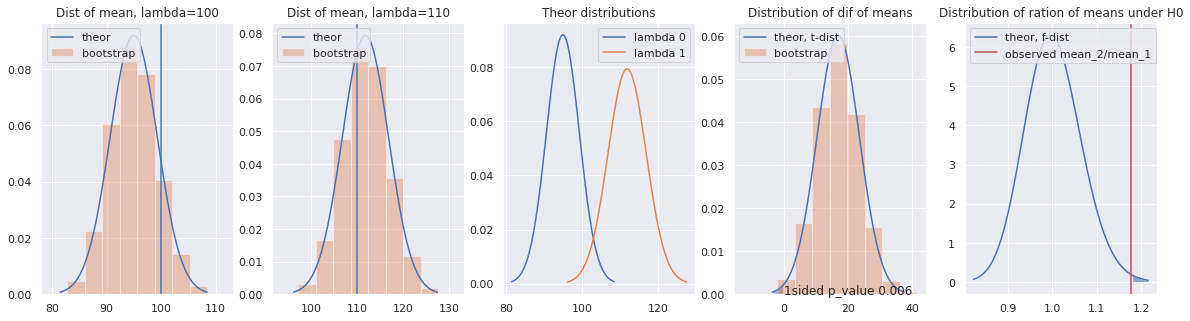

In [28]:
fig, ax = plt.subplots(1, 5)
lambda_list = [lambda_1,lambda_2]
dataset_list = [np.array(dataset_1), np.array(dataset_2)]
sample_mean_list = [d.mean() for d in dataset_list]
sample_std_list = [sqrt(d.var())/sqrt(dataset_size) for d in dataset_list]


for i in range(2):
    dataset = np.array(dataset_list[i])
    sample_mean = sample_mean_list[i]
    sample_std =  sample_std_list[i]
    theor_d = t(dataset_size-1, loc=sample_mean, scale=sample_std)
    x = np.linspace(theor_d.ppf(0.001),theor_d.ppf(0.999), 100)
    ax[i].plot(x, theor_d.pdf(x), label='theor')
    ax[i].hist(f_bootstrap(dataset, np.mean), density = True, alpha = 0.4, label = 'bootstrap')
    ax[i].axvline(x=lambda_list[i])
    ax[i].set_title('Dist of mean, lambda='+str(lambda_list[i]))
    ax[i].legend(loc = 'upper left')
    ax[2].plot(x, theor_d.pdf(x), label = 'lambda '+str(i)) 
ax[2].legend()
ax[2].set_title('Theor distributions')

df = fun_get_df_in_ttest(sample_std_list[0]**2, sample_std_list[1]**2,  dataset_size, dataset_size)
theor_d_dif = t(df, sample_mean_list[1] - sample_mean_list[0], sqrt(sample_std_list[0]**2 + sample_std_list[1]**2))
x = np.linspace(theor_d_dif.ppf(0.001),theor_d_dif.ppf(0.999), 100)
y = theor_d_dif.pdf(x)
ax[3].plot(x, y, label = 'theor, t-dist')
ax[3].set_title('Distribution of dif of means')
p_value_1s = theor_d_dif.cdf(0)
ax[3].fill_between(x, 0, y, where=x<0, alpha=0.6)
ax[3].annotate(f"1sided p_value {p_value_1s:0.3f}", (0,0))
bootstrap_diff_list = f_bootstrap_for_dif(dataset_1, dataset_2, np.mean)
ax[3].hist(bootstrap_diff_list,  density = True, alpha = 0.4, label = 'bootstrap')
ax[3].legend(loc = 'upper left')


mean_ration = sample_mean_list[1]/sample_mean_list[0]
theor_f_dist = f(dataset_size*2, dataset_size*2)
x = np.linspace(theor_f_dist.ppf(0.001),theor_f_dist.ppf(0.999), 100)
y = theor_f_dist.pdf(x)
ax[4].plot(x, y, label = 'theor, f-dist')
ax[4].set_title('Distribution of ration of means under H0')
f_stat_p_value = 1-theor_f_dist.cdf(mean_ration)
ax[4].fill_between(x, 0, y, where=x>mean_ration, alpha=0.6)
ax[4].annotate(f"1sided p_value {f_stat_p_value :0.3f}", (f_stat_p_value,0))
ax[4].axvline(x=mean_ration, label = 'observed mean_2/mean_1', c = 'r')
ax[4].legend(loc = 'upper left')

fig.set_size_inches(20, 5)

print(f"For two data samples with lambda=[{lambda_1},{lambda_2}] and size {dataset_size} \n")

print("2 sided p-values in dif methods:")
stats_p_value = stats.ttest_ind(dataset_1, dataset_2)[1]
print(f"T-test from stats: {stats_p_value:0.4f}")
theor_p_value = 2*p_value_1s
print(f"T-test theoretical: {theor_p_value:0.4f}")
bootstrap_p_value = 2*f_bootstrap_p_value(bootstrap_diff_list)
print(f"Bootstrap for means: {bootstrap_p_value:0.4f}")
print(f"F-test for ration of means: {2*f_stat_p_value:0.4f}")


F-test is more sensetive.
Bootstrap for means is not very stable (I use 20 000 resamplings, mayde it's not enough).

#### Bootstrap for quantile

1sided p value (group_2 > group_1): 0.0957


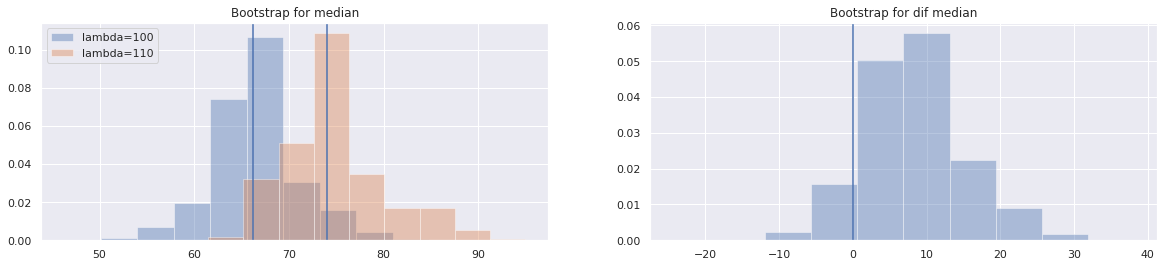

In [32]:
f_make_bootstrap_with_draw(dataset_list, lambda_list, np.quantile, q=0.5)

1sided p value (group_2 > group_1): 0.0202


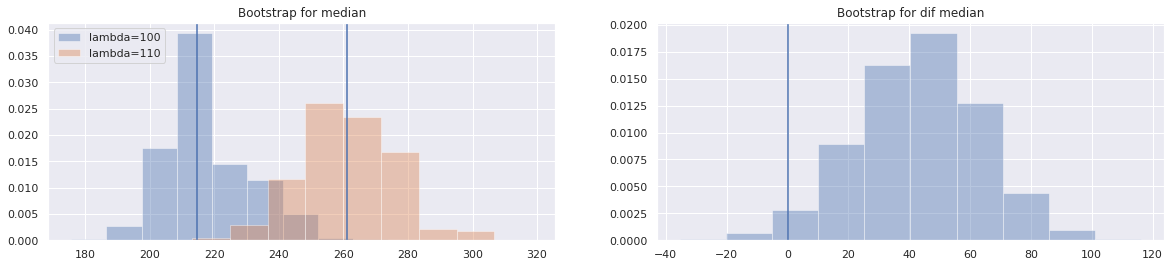

In [33]:
f_make_bootstrap_with_draw(dataset_list, lambda_list, np.quantile, q=0.9)